In [1]:
!pip install numpy librosa scikit-learn tensorflow matplotlib ipython

In [2]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Bidirectional, LSTM, TimeDistributed, Reshape, BatchNormalization, Activation, Multiply, Permute, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from IPython.display import Audio, display
from collections import Counter
import matplotlib.pyplot as plt
import random

2025-08-02 08:24:38.902395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754123079.075669      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754123079.128732      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# PARAMETERS
SR = 22050
DURATION = 2.5
SAMPLES_PER_TRACK = int(SR * DURATION)
N_MELS = 128

In [4]:
# FEATURE EXTRACTION FUNCTION
def extract_features(file_path):
    try:
        signal, sr = librosa.load(file_path, sr=SR)
        if len(signal) < SAMPLES_PER_TRACK:
            pad_length = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, pad_length))
        else:
            signal = signal[:SAMPLES_PER_TRACK]
        mel = librosa.feature.melspectrogram(y=signal, sr=SR, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - np.mean(mel_db)) / (np.std(mel_db) + 1e-6)  # Normalization
        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [5]:
# LOAD DATA FROM RAVDESS
data_dir = '/kaggle/input/ravdess-emotional-speech-audio'
emotion_labels = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

X, y = [], []
file_paths = []

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_code = file.split("-")[2]
            emotion = emotion_labels.get(emotion_code)
            if emotion:
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(emotion)
                    file_paths.append(file_path)

print("Label Distribution:", Counter(y))

X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

Label Distribution: Counter({'surprised': 384, 'disgust': 384, 'fearful': 384, 'sad': 384, 'calm': 384, 'happy': 384, 'angry': 384, 'neutral': 192})


In [6]:
# DATA AUGMENTATION
def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def time_stretch(signal, rate=0.8):
    return librosa.effects.time_stretch(signal, rate=rate)

def pitch_shift(signal, sr, n_steps=2):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

augmented_X, augmented_y = [], []
for i in range(len(file_paths)):
    path = file_paths[i]
    label = y[i]
    signal, sr = librosa.load(path, sr=SR)

    signal = signal[:SAMPLES_PER_TRACK] if len(signal) > SAMPLES_PER_TRACK else np.pad(signal, (0, SAMPLES_PER_TRACK - len(signal)))

    for augment_fn in [
        lambda s: add_noise(s),
        lambda s: time_stretch(s, rate=0.9),
        lambda s: pitch_shift(s, sr=SR, n_steps=2)
    ]:
        try:
            augmented_signal = augment_fn(signal)
            augmented_signal = augmented_signal[:SAMPLES_PER_TRACK] if len(augmented_signal) > SAMPLES_PER_TRACK else np.pad(augmented_signal, (0, SAMPLES_PER_TRACK - len(augmented_signal)))
            mel = librosa.feature.melspectrogram(y=augmented_signal, sr=SR, n_mels=N_MELS)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_db = (mel_db - np.mean(mel_db)) / (np.std(mel_db) + 1e-6)
            augmented_X.append(mel_db)
            augmented_y.append(label)
        except:
            continue

X = np.concatenate([X, np.expand_dims(np.array(augmented_X), -1)], axis=0)
y += augmented_y

print("Label Distribution After Augmentation:", Counter(y))

Label Distribution After Augmentation: Counter({'surprised': 1536, 'disgust': 1536, 'fearful': 1536, 'sad': 1536, 'calm': 1536, 'happy': 1536, 'angry': 1536, 'neutral': 768})


In [7]:
# ENCODE LABELS
le = LabelEncoder()
y_int = le.fit_transform(y)
y_encoded = to_categorical(y_int)

In [8]:
# CLASS WEIGHTS
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

Class Weights: {0: 0.9375, 1: 0.9375, 2: 0.9375, 3: 0.9375, 4: 0.9375, 5: 1.875, 6: 0.9375, 7: 0.9375}


In [9]:
# SPLIT DATA
X_train, X_test, y_train, y_test, y_train_int, y_test_int = train_test_split(
    X, y_encoded, y_int, test_size=0.2, random_state=42, stratify=y_int
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (9216, 128, 108, 1) (9216, 8)
Test shape: (2304, 128, 108, 1) (2304, 8)


In [10]:
# CRNN MODEL WITH FIXED ATTENTION
def attention_layer(inputs):
    time_steps = int(inputs.shape[1])
    input_dim = int(inputs.shape[2])
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

input_shape = (X.shape[1], X.shape[2], 1)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Reshape for LSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = attention_layer(x)
x = Flatten()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(np.unique(y_int)), activation='softmax')(x)

emotion_model = Model(inputs, outputs)
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
emotion_model.summary()

I0000 00:00:1754123361.596482      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754123361.597132      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 108,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 108,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 108,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 108,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 54,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 54,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 54,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 54,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 27,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 27,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 864, 64)   │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 864, 128)  │     66,048 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 864, 128)  │     16,512 │ bidirectional[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 864, 128)  │          0 │ bidirectional[0]… │
│                     │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 110592)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 110592)    │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 14,155,904 │ dropout_2[0][0] 

 Total params: 14,258,696 (54.39 MB)

 Trainable params: 14,258,504 (54.39 MB)

 Non-trainable params: 192 (768.00 B)

In [11]:
# TRAINING
checkpoint = ModelCheckpoint("emotion_detection_crnn_attention.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
history = emotion_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, lr_scheduler],
    class_weight=class_weights
)

Epoch 1/50


E0000 00:00:1754123369.914193      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1754123370.264751      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2684 - loss: 1.8515
Epoch 1: val_accuracy improved from -inf to 0.48785, saving model to emotion_detection_crnn_attention.h5
288/288 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.2688 - loss: 1.8507 - val_accuracy: 0.4878 - val_loss: 1.4235 - learning_rate: 0.0010
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5789 - loss: 1.1345
Epoch 2: val_accuracy improved from 0.48785 to 0.67839, saving model to emotion_detection_crnn_attention.h5
288/288 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5790 - loss: 1.1343 - val_accuracy: 0.6784 - val_loss: 0.9023 - learning_rate: 0.0010
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7417 - loss: 0.7220
Epoch 3: val_accuracy improved from 0.67839 to 0.81554, saving model to emotion_detection_crnn_attention.h5
288/288 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.7417 - loss: 0.7219 - val_accuracy: 0.8155 - val_loss: 0.5294 - learning_rate: 0.001

In [12]:
emotion_model.save("emotions_model.keras", save_format="keras")

In [13]:
# EVALUATION
y_pred = emotion_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test_int, y_pred_labels, target_names=le.classes_))

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.98      0.99      0.99       307
        calm       0.92      0.95      0.94       307
     disgust       0.98      0.95      0.96       307
     fearful       0.99      0.94      0.96       307
       happy       0.97      0.97      0.97       307
     neutral       0.89      0.95      0.92       154
         sad       0.96      0.95      0.96       307
   surprised       0.99      0.99      0.99       308

    accuracy                           0.96      2304
   macro avg       0.96      0.96      0.96      2304
weighted avg       0.96      0.96      0.96      2304



In [14]:
# RANDOM PREDICTIONS
indices = random.sample(range(len(X_test)), 10)
for idx in indices:
    pred = emotion_model.predict(np.expand_dims(X_test[idx], axis=0))[0]
    actual = le.classes_[np.argmax(y_test[idx])]
    predicted = le.classes_[np.argmax(pred)]
    print(f"Actual: {actual}, Predicted: {predicted}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Actual: calm, Predicted: calm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Actual: disgust, Predicted: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual: happy, Predicted: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Actual: sad, Predicted: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Actual: surprised, Predicted: surprised
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Actual: sad, Predicted: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Actual: sad, Predicted: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Actual: neutral, Predicted: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Actual: fearful, Predicted: fearful
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual: happy, Predicted: happy


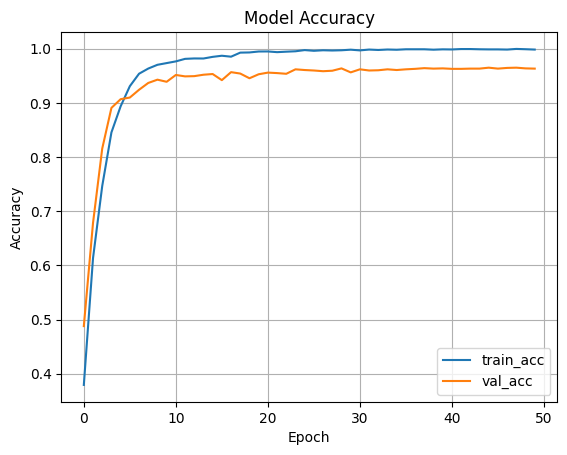

In [15]:
# PLOT ACCURACY
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()